<a href="https://colab.research.google.com/github/byrzhm/lavila-demo/blob/main/Copy_of_lavila_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Learning Video Representations from Large Language Models

<img align="center" src="" width="800">

This is a colab demo of using LaViLa (A **L**anguage-model **a**ugmented **Vi**deo-**La**nguage Pre-training).

You can make a copy of this tutorial by "File -> Open in playground mode" and make changes there. __DO NOT__ request access to this tutorial.

LaViLa has three components: *Rephraser*, *Narrator*, and *Dual-Encoder*.
This is a demo to show how to use narrator to narrate a video clip.

(Due to memory constraint, we use a base model here. If you want to use a stronger model, please checkout [our repo](https://github.com/fairinternal/LaViLa/tree/dev#narrator) and run demo locally.)


In [ ]:
!git clone https://github.com/facebookresearch/LaViLa.git lavila
%cd lavila

In [ ]:
# downgraded dependencies for python 3.7
# (slightly different from $LAVILA_ROOT/requirements.txt)
!pip install timm==0.5.4
!pip install torch==1.10.1
!pip install torchvision==0.11.2
!pip install decord==0.6.0
!pip install einops==0.4.1
!pip install pandas==1.3.5
!pip install pytorchvideo==0.1.5
!pip install transformers==4.21
!pip install ftfy==4.4.3
!pip install spacy==3.4.1
!pip install scikit-learn==1.0.2
!pip install git+https://github.com/Maluuba/nlg-eval.git@master

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.5/431.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 16.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 706.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 9.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [ ]:
import decord
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

import torch
import torchvision.transforms as transforms
import torchvision.transforms._transforms_video as transforms_video

import sys
sys.path.insert(0, './')
from lavila.data.video_transforms import Permute
from lavila.data.datasets import get_frame_ids, video_loader_by_frames
from lavila.models.models import VCLM_OPENAI_TIMESFORMER_BASE_GPT2
from lavila.models.tokenizer import MyGPT2Tokenizer

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_functional_video.py:6: UserWarning: The 'torchvision.transforms._functional_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms.functional' module instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/transforms/_transforms_video.py:22: UserWarning: The 'torchvision.transforms._transforms_video' module is deprecated since 0.12 and will be removed in the future. Please use the 'torchvision.transforms' module instead.
  warnings.warn(


ModuleNotFoundError: No module named 'transformers.generation'

In [ ]:
# Take an example video. Replace path here to try your own video!
# Note that the ego4d clips for pre-training have an average duration of 1 (±0.9) sec.
# Therefore you might want your own video to have a similar duration as well,
# epseically if you want the model to describe some atomic actions
video_path = 'assets/3c0dffd0-e38e-4643-bc48-d513943dc20b_012_014.mp4'

from IPython.display import HTML
from base64 import b64encode

def show_video(video_path, video_width = 600):

  video_file = open(video_path, "r+b").read()

  video_url = f"data:video/mp4;base64,{b64encode(video_file).decode()}"
  return HTML(f"""<video width={video_width} controls><source src="{video_url}"></video>""")

show_video(video_path)

In [ ]:
# The video is represented by `num_seg=4` frames
vr = decord.VideoReader(video_path)
num_seg = 4
frame_ids = get_frame_ids(0, len(vr), num_segments=num_seg, jitter=False)
frames = video_loader_by_frames('./', video_path, frame_ids)

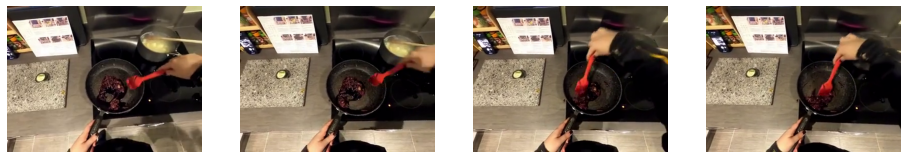

In [ ]:
# display the subsampled frames
plt.figure(figsize=(16, 40))
for i in range(num_seg):
  plt.subplot(1, num_seg, i + 1)
  plt.imshow(frames[i].cpu().numpy().astype(int))
  plt.axis('off')
plt.show()

In [ ]:
# download the pre-trained weights
!wget https://dl.fbaipublicfiles.com/lavila/checkpoints/narrator/vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth
ckpt_path = 'vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth'
ckpt = torch.load(ckpt_path, map_location='cpu')
state_dict = OrderedDict()
for k, v in ckpt['state_dict'].items():
  state_dict[k.replace('module.', '')] = v

--2022-12-07 21:42:47--  https://dl.fbaipublicfiles.com/lavila/checkpoints/narrator/vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 104.22.74.142, 172.67.9.4, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|104.22.74.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1325978405 (1.2G) [binary/octet-stream]
Saving to: ‘vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth’

vclm_openai_timesfo 100%[===================>]   1.23G  37.1MB/s    in 38s     

2022-12-07 21:43:26 (33.3 MB/s) - ‘vclm_openai_timesformer_base_gpt2_base.pt_ego4d.jobid_319630.ep_0002.md5sum_68a71f.pth’ saved [1325978405/1325978405]



In [ ]:
# instantiate the model, and load the pre-trained weights
model = VCLM_OPENAI_TIMESFORMER_BASE_GPT2(
    text_use_cls_token=False,
    project_embed_dim=256,
    gated_xattn=True,
    timesformer_gated_xattn=False,
    freeze_lm_vclm=False,
    freeze_visual_vclm=False,
    freeze_visual_vclm_temporal=False,
    num_frames=4,
    drop_path_rate=0.
)
model.load_state_dict(state_dict, strict=True)
model.eval()

######USING ATTENTION STYLE:  frozen-in-time


100%|███████████████████████████████████████| 335M/335M [00:04<00:00, 71.3MiB/s]


=> Loading CLIP (ViT-B/16) weights
_IncompatibleKeys(missing_keys=['temporal_embed', 'blocks.0.timeattn.qkv.weight', 'blocks.0.timeattn.qkv.bias', 'blocks.0.timeattn.proj.weight', 'blocks.0.timeattn.proj.bias', 'blocks.0.norm3.weight', 'blocks.0.norm3.bias', 'blocks.1.timeattn.qkv.weight', 'blocks.1.timeattn.qkv.bias', 'blocks.1.timeattn.proj.weight', 'blocks.1.timeattn.proj.bias', 'blocks.1.norm3.weight', 'blocks.1.norm3.bias', 'blocks.2.timeattn.qkv.weight', 'blocks.2.timeattn.qkv.bias', 'blocks.2.timeattn.proj.weight', 'blocks.2.timeattn.proj.bias', 'blocks.2.norm3.weight', 'blocks.2.norm3.bias', 'blocks.3.timeattn.qkv.weight', 'blocks.3.timeattn.qkv.bias', 'blocks.3.timeattn.proj.weight', 'blocks.3.timeattn.proj.bias', 'blocks.3.norm3.weight', 'blocks.3.norm3.bias', 'blocks.4.timeattn.qkv.weight', 'blocks.4.timeattn.qkv.bias', 'blocks.4.timeattn.proj.weight', 'blocks.4.timeattn.proj.bias', 'blocks.4.norm3.weight', 'blocks.4.norm3.bias', 'blocks.5.timeattn.qkv.weight', 'blocks.5.tim

Loading LM from pretrained weights..


VCLM_HF(
  (visual): SpaceTimeTransformer(
    (patch_embed): VideoPatchEmbed(
      (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), bias=False)
    )
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): SpaceTimeBlock(
        (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): VarAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (timeattn): VarAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_pat

In [ ]:
# transforms on input frames
crop_size = 224
val_transform = transforms.Compose([
    Permute([3, 0, 1, 2]),
    transforms.Resize(crop_size),
    transforms.CenterCrop(crop_size),
    transforms_video.NormalizeVideo(mean=[108.3272985, 116.7460125, 104.09373615000001], std=[68.5005327, 66.6321579, 70.32316305])
])
frames = val_transform(frames)
frames = frames.unsqueeze(0)  # fake a batch dimension

In [ ]:
tokenizer = MyGPT2Tokenizer('gpt2', add_bos=True)
with torch.no_grad():
  image_features = model.encode_image(frames)
  generated_text_ids, ppls = model.generate(
      image_features,
      tokenizer,
      target=None, # free-form generation
      max_text_length=77,
      top_k=None,
      top_p=0.95,  # nucleus sampling
      num_return_sequences=10, # number of candidates: 10
      temperature=0.7,
      early_stopping=True,
  )

=> Initialize MyGPT2Tokenizer (gpt2)


In [ ]:
def decode_one(generated_ids, tokenizer):
    # get the index of <EOS>
    if tokenizer.eos_token_id == tokenizer.bos_token_id:
        if tokenizer.eos_token_id in generated_ids[1:].tolist():
            eos_id = generated_ids[1:].tolist().index(tokenizer.eos_token_id) + 1
        else:
            eos_id = len(generated_ids.tolist()) - 1
    elif tokenizer.eos_token_id in generated_ids.tolist():
        eos_id = generated_ids.tolist().index(tokenizer.eos_token_id)
    else:
        eos_id = len(generated_ids.tolist()) - 1
    generated_text_str = tokenizer.tokenizer.decode(generated_ids[1:eos_id].tolist())
    return generated_text_str

for i in range(10):
  generated_text_str = decode_one(generated_text_ids[i], tokenizer)
  print('{}: {}'.format(i, generated_text_str))

0: #C C stirs food
1: #C C stirs food with a spoon
2: #C C stirs the food
3: #C C stirs food in the cooking pan with a spat
4: #C C stirs the stew.
5: #C C stirs food in the pan.
6: #C C stirs the food
7: #C C stirs the food.
8: #C C stirs the food.
9: #C C stirs the food.
